In [1]:
import pandas as pd
import numpy as np
import ipaddress
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## 1. The model and filtered data are loaded

In [2]:
classifier = load_model("modelo_principal.keras")

In [ ]:
X_filtered = pd.read_csv("X_filtered.csv")

## 2. GAN training 

In [8]:
# Parámetros
input_dim = 90  # vector aleatorio que usará el generador para crear el ruido
data_dim = 26   # tamaño de la entrada al clasificador
num_classes = 1  #salida para el tipo de ataque
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Generador: crea datos sintéticos que "parezcan" reales
def build_generator():
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dense(data_dim, activation= "linear"))  
    return model

# GAN combinada
def build_gan(generator, classifier):
    classifier.trainable = False  # congelamos el modelo original para que los pesos no cambien
    model= tf.keras.models.Sequential([generator, classifier])
    return model

# Definimos una función de pérdida personalizada
    
def custom_generator_loss(y_true, y_pred, generated_data, alpha=0.2, target_mean=0.3):
    # Pérdida adversarial normal (engañar al clasificador)
    adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(y_pred), y_pred))

    # Penalización: queremos que la media por columna sea cercana a un cierto valor
    mean_per_col = tf.reduce_mean(generated_data, axis=0)
    mean_loss = tf.reduce_mean(tf.nn.relu(target_mean - mean_per_col))  # penaliza solo si está por debajo

    # Combinar las pérdidas
    return adv_loss + alpha * mean_loss


# Construcción de la GAN
generator = build_generator()
gan = build_gan(generator, classifier)
generator_optimizer = Adam(
    learning_rate = 0.0001,
    beta_1 = 0.5,
    beta_2 = 0.999
)
gan.compile(optimizer=generator_optimizer, loss=custom_generator_loss)

# Early stopping personalizado
patience = 2000
min_delta = 0.01 
best_loss = float('inf')
patience_counter = 0

# Entrenamiento
batch_size = 64
epochs = 5000
losses = []

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, input_dim))

    with tf.GradientTape() as tape:
        generated_data = generator(noise, training=True)
        predictions = classifier(generated_data, training=False)
        loss = custom_generator_loss(tf.zeros((batch_size, 1)), predictions, generated_data, alpha=0.2)
        losses.append(loss)

    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    print(f"Epoch {epoch} - Loss: {loss.numpy():.4f}")

     # Early stopping
    if best_loss - loss.numpy() > min_delta:
        best_loss = loss.numpy()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        break

Epoch 0 - Loss: 0.2892
Epoch 1 - Loss: 0.1795
Epoch 2 - Loss: 0.3481
Epoch 3 - Loss: 0.8980
Epoch 4 - Loss: 0.2650
Epoch 5 - Loss: 0.4060
Epoch 6 - Loss: 0.1972
Epoch 7 - Loss: 0.3825
Epoch 8 - Loss: 0.1749
Epoch 9 - Loss: 0.1677
Epoch 10 - Loss: 0.1990
Epoch 11 - Loss: 0.7570
Epoch 12 - Loss: 0.1601
Epoch 13 - Loss: 0.1366
Epoch 14 - Loss: 0.1628
Epoch 15 - Loss: 0.2386
Epoch 16 - Loss: 0.0991
Epoch 17 - Loss: 0.3120
Epoch 18 - Loss: 0.1281
Epoch 19 - Loss: 0.3224
Epoch 20 - Loss: 0.0929
Epoch 21 - Loss: 0.5177
Epoch 22 - Loss: 0.1198
Epoch 23 - Loss: 0.5949
Epoch 24 - Loss: 0.1142
Epoch 25 - Loss: 0.0971
Epoch 26 - Loss: 0.2236
Epoch 27 - Loss: 0.6169
Epoch 28 - Loss: 0.2413
Epoch 29 - Loss: 0.1434
Epoch 30 - Loss: 0.0916
Epoch 31 - Loss: 0.1042
Epoch 32 - Loss: 0.5292
Epoch 33 - Loss: 0.5172
Epoch 34 - Loss: 0.1052
Epoch 35 - Loss: 0.0953
Epoch 36 - Loss: 0.3224
Epoch 37 - Loss: 0.1902
Epoch 38 - Loss: 0.1908
Epoch 39 - Loss: 0.0864
Epoch 40 - Loss: 0.0918
Epoch 41 - Loss: 0.2954
Ep

## 3. GAN loss representation

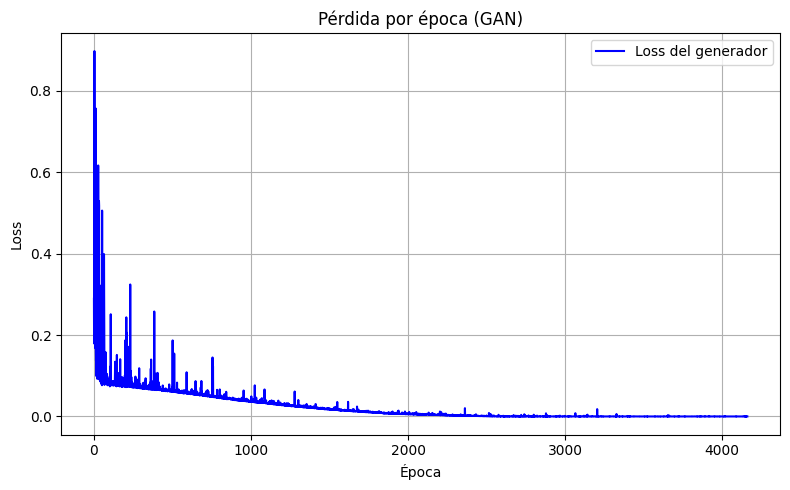

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss del generador', color='blue')
plt.title('Pérdida por época (GAN)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Save the generator

In [ ]:
gan.save("gan2.keras")

In [ ]:
generator.save("generator2.keras")